__Chapter 13 - Parallelizing Neural Network Training with TensorFlow__

1. [Import](#Import)
1. [First steps with TensoFlow](#First-steps-with-TensoFlow)
    1. [Working with array structures](#Working-with-array-structures)
    1. [Developing a simple model with the low-level TensorFlow API](#Developing-a-simple-model-with-the-low-level-TensorFlow-API)
1. [Training neural networks efficiently with high-level TensorFlow APIs](#Training-neural-networks-efficiently-with-high-level-TensorFlow-APIs)
    1. [Building multilayer neural networks using TensorFlow's Layers API](#Building-multilayer-neural-networks-using-TensorFlows-Layers-API)
    1. [Developing a multilayer neural network with Keras](#Developing-a-multilayer-neural-network-with-Keras)
1. [Choosing activation functions for multilayer networks](#Choosing-activation-functions-for-multilayer-networks)
    1. [Logistic function recap](#Logistic-function-recap)
    1. [Estimating class probabilities in multiclass classification via the softmax function](#Estimating-class-probabilities-in-multiclass-classification-via-the-softmax-function)
    1. [Broadening the output spectrum using a hyperbolic tangent](#Broadening-the-output-spectrum-using-a-hyperbolic-tangent)
    1. [Rectified linear unit activation](#Rectified-linear-unit-activation)




# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# First steps with TensoFlow

TensorFlow is built around a computation graphs composed of a node set. Each node represents and operation that may have zero or more input or output. The values that flow through the edges of the computation graph are referred to as tensors.

Tensors can be scalars, vectors, matrices, and so on. A scalar is a rank-0 tensor, a vector is a rank-1 tensor, a matrix is a rank-2 tensor, and matrices stacked to form a three dimensional array are rank-3 tensors.

We need to build the computation graph and launch it in a TensorFlow session. As a simple warm-up, we start with the use of scalars from TensorFlow to compute a net input $z$ of a sample point $x$ in a 1-dimensional dataset with weight $w$ and bias $b$.

$$
z = wx + b
$$

The following code shows how to implement this equation in the lower-level TensorFlow API. In general, the low-level API requires that we define placeholders for input data (x, y and sometimes other tunable parameters). Then we define the weight matrices, and if this is an optimization algorithm we need to define the loss or cost function to use. TensoFlow creates a graph that contains all the sybmols we define as nodes in this graph

<a id = 'First-steps-with-TensoFlow'></a>

In [2]:
# load TensorFlow and check version
import tensorflow as tf

print(tf.__version__)

1.13.1


In [3]:
# create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name="x")
    w = tf.Variable(2.0, name="weight")
    b = tf.Variable(0.7, name="bias")
    z = w * x + b

    init = tf.global_variables_initializer()

# create a session and pass in graph g
with tf.Session(graph=g) as sess:

    # initialize w and b
    sess.run(init)

    # evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print("x = {:.2f} --> {:.2f}".format(t, sess.run(z, feed_dict={x: t})))

Instructions for updating:
Colocations handled automatically by placer.
x = 1.00 --> 2.70
x = 0.60 --> 1.90
x = -1.80 --> -2.90


the placeholder for the variable x with shape = (None) allows us to feed the values in an element-by-element form, as well as in batch form where we feed in all the input data at once. The latter implementation would be as follows:

In [4]:
# batch form
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x: [1.0, 2.0, 3.0]}))

[2.7 4.7 6.7]


## Working with array structures

As an example of how to use array structures, we will create a simple rank-3 tensor of size _batchsize_ x 2 x 3, reshape it, and calculate the column sums using TensorFlow's optimized expression. We generally won't know the batch size beforehand, so we specify None for the batch size in the argument for the shape parameter of the placeholder x.



<a id = 'Working-with-array-structures'></a>

In [5]:
#  create graph and session
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name="input_x")
    x2 = tf.reshape(x, shape=(-1, 6), name="x2")

    # calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name="col_sum")

    # calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name="col_sum")

with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print("Original array:\n {}".format(x_array))
    print("input shape: {}".format(x_array.shape))
    print("Reshaped: \n {0}".format(sess.run(x2, feed_dict={x: x_array})))
    print("Column sums: \n {0}".format(sess.run(xsum, feed_dict={x: x_array})))
    print("Column means: \n {0}".format(sess.run(xmean, feed_dict={x: x_array})))

Original array:
 [[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
input shape: (3, 2, 3)
Reshaped: 
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column sums: 
 [18. 21. 24. 27. 30. 33.]
Column means: 
 [ 6.  7.  8.  9. 10. 11.]


We used three functions - tf.reshape, tf.reduce_mean, tf.reduce_sum. The value -1 is used when reshaping because we don't know the batch size. Using -1 in TensorFlow when reshaping means the size of that dimensions will be computed according to the total size of the tensor and the other dimensions. Something like tf.reshape(tensor, shape = (-1,) can be used to flatten a tensor.

# Developing a simple model with the low-level TensorFlow API

Implement an ordinary least squares regressioin model. Let's create a small 1-dimensional dataset with 10 training samples. We want to train a linear regression model to predict the output $y$ from the input $x$, per usual. We will implement this model in a class that we will call TfLinreg. We need two placeholders, one for the input $x$ and one for the output $y$ in order to feed the data into ourmodel. We also need the trainable variables $w$ and $b$ for the weight and bias.

With these, we can then define the linear regression model $z= w \times x + b$, as well as the cost function. For this function we will use Mean Squared Error. To learn the weights, we will use gradient descent.

<a id = 'Developing-a-simple-model-with-the-low-level-TensorFlow-API'></a>

In [6]:
# create train and test sets
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [7]:
# custom class implementing linear regression with TensorFlow
class TfLinReg:
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):

        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()

        # build model
        with self.g.as_default():

            # set graph-level random-seed
            tf.set_random_seed(random_seed)
            self.build()

            # create initializer
            self.init_op = tf.global_variables_initializer()

    def build(self):

        # define placeholders for inputs
        self.X = tf.placeholder(
            dtype=tf.float32, shape=(None, self.x_dim), name="x_input"
        )
        self.y = tf.placeholder(dtype=tf.float32, shape=(None), name="y_input")
        print(self.X)
        print(self.y)

        # define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)), name="weight")
        b = tf.Variable(tf.zeros(shape=(1)), name="bias")
        print(w)
        print(b)

        self.z_net = tf.squeeze(w * self.X + b, name="z_net")
        print(self.z_net)

        sqr_errors = tf.square(self.y - self.z_net, name="sqr_errors")
        print(sqr_errors)

        self.mean_cost = tf.reduce_mean(sqr_errors, name="mean_cost")

        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate, name="GradientDescent"
        )
        self.optimizer = optimizer.minimize(self.mean_cost)

In [8]:
# fit model
lrmodel = TfLinReg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)
Instructions for updating:
Use tf.cast instead.


The print statements display information about the six nodes in the graph $X$, $y$, $w$, $b$, $z\_net$, $sqr\_errors$. Now we need to implement a training function to learn the weights of the linear regression model. To train the model, we implement a separate function that requires a TensorFlow session, model instance, training data and the number of epochs. In the following function, we initialize the variables in the TensorFlow session using the init_op operation defined in the mode. Then we iterate and call the optimizer operation of the model while feeding the training data. This functions returns a list of training costs.

In [9]:
# custom function for capturing training costs
def train_linreg(sess, model, X_train, y_train, num_epochs=10):

    # initialize all variables: W and b
    sess.run(model.init_op)

    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run(
            [model.optimizer, model.mean_cost],
            feed_dict={model.X: X_train, model.y: y_train},
        )
        training_costs.append(cost)

    return training_costs

In [10]:
# create a new TensorFlwo session to launch the lrmodel.g graph
sess = tf.Session(graph=lrmodel.g)

# pass all required arguments to the train_linreg function for training
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

In [11]:
np.arange(1, len(training_costs) + 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

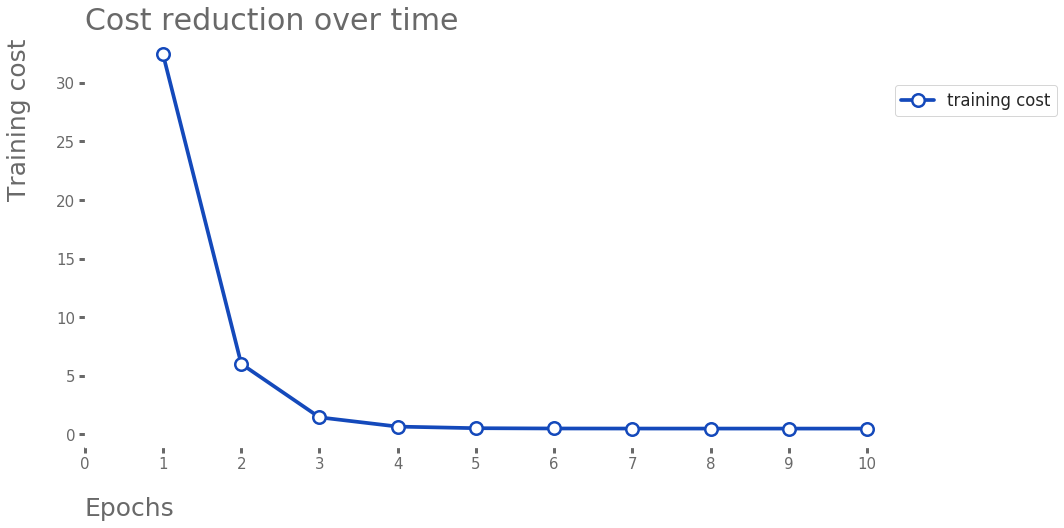

In [12]:
# visualize training cost by epoch
p = PrettierPlot()
ax = p.make_canvas(
    title="Cost reduction over time",
    xLabel="Epochs",
    yLabel="Training cost",
    y_shift=0.6,
)
p.prettyLine(
    x=np.arange(1, len(training_costs) + 1),
    y=np.array(training_costs),
    label="training cost",
    linecolor=style.styleHexMid[0],
    xTicks=np.arange(0, 11, 1),
    bbox=(1.2, 0.9),
    marker_on=True,
    ax=ax,
)

We need to add a function to make predictions based on input features. This function will need the TensorFlow session, model and the test data.

In [13]:
# function to make predictions. Simply run z_net in the previously defined graph
def predict_linreg(sess, model, X_test):
    yPred = sess.run(model.z_net, feed_dict={model.X: X_test})
    return yPred

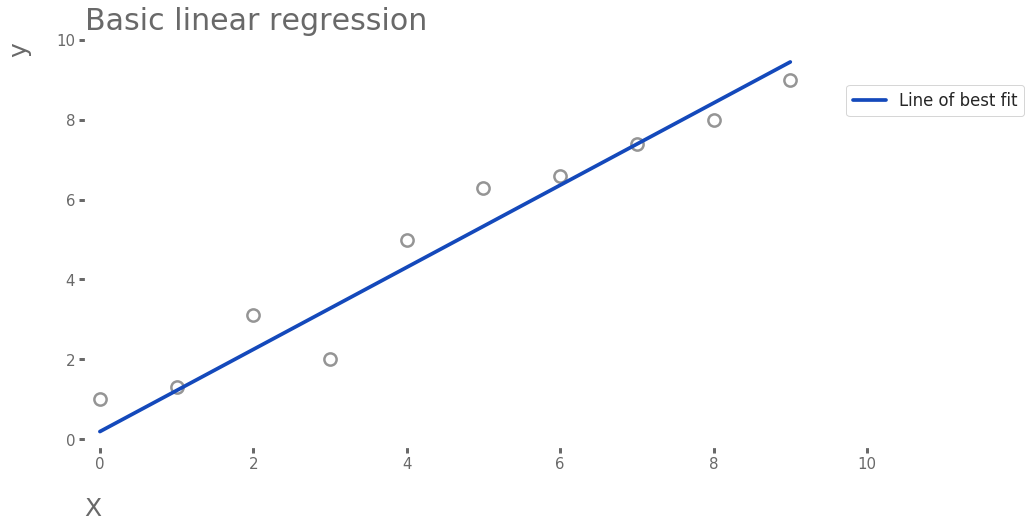

In [14]:
# visualize line of best fit
p = PrettierPlot()
ax = p.make_canvas(title="Basic linear regression", xLabel="X", yLabel="y", y_shift=0.95)
p.pretty_2d_scatter(x=X_train, y=y_train, x_units="f", y_units="f", ax=ax)

p.prettyLine(
    x=np.arange(X_train.shape[0]),
    y=predict_linreg(sess, lrmodel, X_train),
    label="Line of best fit",
    linecolor=style.styleHexMid[0],
    bbox=(1.2, 0.9),
    marker_on=False,
    ax=ax,
)

# Training neural networks efficiently with high-level TensorFlow APIs

We will review two high-level TensorFlow APIs, the Layers API and Keras API

<a id = 'Training-neural-networks-efficiently-with-high-level-TensorFlow-APIs'></a>

## Building multilayer neural networks using TensorFlow's Layers API

<a id = 'Building-multilayer-neural-networks-using-TensorFlows-Layers-API'></a>

In [15]:
# Load data and print dimensions
df_train = pd.read_csv("s3://tdp-ml-datasets/kaggle-mnist//train.csv", sep=",")
df_test = pd.read_csv("s3://tdp-ml-datasets/kaggle-mnist//test.csv", sep=",")

print("Training data dimensions: {}".format(df_train.shape))
print("Test data dimensions: {}".format(df_test.shape))

# separate
df_train_label = df_train["label"]
df_train = df_train.drop(labels="label", axis=1)

# train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_train, df_train_label, test_size=0.2
)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Training data dimensions: (42000, 785)
Test data dimensions: (28000, 784)


In [16]:
# split into train/test data
print("Training data dimensions: {}".format(X_train.shape))
print("Test data dimensions: {}".format(X_test.shape))

Training data dimensions: (33600, 784)
Test data dimensions: (8400, 784)


In [17]:
# standardize data
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)
X_trainCentered = (X_train - mean_vals) / std_val
X_testCentered = (X_test - mean_vals) / std_val
print(
    "X_trainCentered  dimensions: {}, training label shape: {}".format(
        X_trainCentered.shape, y_train.shape
    )
)
print(
    "X_testCentered  dimensions: {}, training label shape: {}".format(
        X_testCentered.shape, y_test.shape
    )
)

X_trainCentered  dimensions: (33600, 784), training label shape: (33600,)
X_testCentered  dimensions: (8400, 784), training label shape: (8400,)


With this data in hand, we will start building the model by creating two placeholders, named tf_x and tf_y, and then build an MLP with three fully connected layers. For the activation functions, we will use hyperbolic tangent activation functions (tanh) in the hidden layer, and in the output layer we will use softmax. We will also add an additional hidden layer to get us to three fully connected layers.

In [18]:
# create TensorFlow graph
n_features = X_trainCentered.shape[1]
n_classes = 10
random_seed = 123

np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="tf_x")
    tf_y = tf.placeholder(dtype=tf.int32, shape=None, name="tf_y")
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)

    h1 = tf.layers.dense(inputs=tf_x, units=50, activation=tf.tanh, name="layer1")
    h2 = tf.layers.dense(inputs=h1, units=50, activation=tf.tanh, name="layer2")
    logits = tf.layers.dense(inputs=h2, units=10, activation=None, name="layer3")

    predictions = {
        "classes": tf.argmax(logits, axis=1, name="predicted_classes"),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor"),
    }

with g.as_default():
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot, logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In order to train the network, we need a way to generate batches of data. To do this, we implement a function that returns a generator.

In [19]:
# custom function to generate samples for model
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)

    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)

    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i : i + batch_size, :], y_copy[i : i + batch_size])

In [20]:
# create a new TensorFlow session, initialize variables in our network and train
# create a new session to launch the graph
sess = tf.Session(graph=g)

# run the variable initialization operator
sess.run(init_op)

# 50 epochs of training
for epoch in range(50):
    training_costs = []
    batch_generator = create_batch_generator(X_trainCentered, y_train, batch_size=64)

    for batch_X, batch_y in batch_generator:
        # prepare a dict to feed data to the network
        feed = {tf_x: batch_X, tf_y: batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print("Epoch {0} training loss: {1}".format(epoch + 1, training_costs[-1]))

Epoch 1 training loss: 1.47432541847229
Epoch 2 training loss: 1.1588801145553589
Epoch 3 training loss: 0.9878157377243042
Epoch 4 training loss: 0.8709930181503296
Epoch 5 training loss: 0.7837013006210327
Epoch 6 training loss: 0.7151179313659668
Epoch 7 training loss: 0.6594202518463135
Epoch 8 training loss: 0.613131046295166
Epoch 9 training loss: 0.5740007162094116
Epoch 10 training loss: 0.5404797196388245
Epoch 11 training loss: 0.5114487409591675
Epoch 12 training loss: 0.48606857657432556
Epoch 13 training loss: 0.46369391679763794
Epoch 14 training loss: 0.44381874799728394
Epoch 15 training loss: 0.42604145407676697
Epoch 16 training loss: 0.41003894805908203
Epoch 17 training loss: 0.39554959535598755
Epoch 18 training loss: 0.38235965371131897
Epoch 19 training loss: 0.3702933192253113
Epoch 20 training loss: 0.35920533537864685
Epoch 21 training loss: 0.3489748537540436
Epoch 22 training loss: 0.33950066566467285
Epoch 23 training loss: 0.3306977152824402
Epoch 24 train

In [21]:
# lastly, make predictions with the trained model
feed = {tf_x: X_testCentered}
yPred = sess.run(predictions["classes"], feed_dict=feed)
print("Test accuracy: {:.4f}%".format(100 * np.sum(yPred == y_test) / y_test.shape[0]))

Test accuracy: 92.2619%


# Developing a multilayer neural network with Keras

<a id = 'Developing-a-multilayer-neural-network-with-Keras'></a>

In [22]:
# load keras
import tensorflow.contrib.keras as keras

np.random.seed(123)
tf.set_random_seed(123)

In [23]:
# one-hot encode traiing data
y_train_onehot = keras.utils.to_categorical(y_train)
print("First 5 labels: {}".format(y_train[:5]))
print("\nFirst 5 labels one-hot encoded\n".format(y_train_onehot[:5]))

First 5 labels: [2 8 5 3 9]

First 5 labels one-hot encoded



Build a neural network with three layers, where the first two layers each ahve 50 hidden units with a tanh activation function, and the last layer has 10 layers for each of the 10 class labels and uses softmax to give the probability of each class.

First we initialize a new model using the Sequential class to implement a feedforward neural network. Then we can add as many layers as we want to. The kernel_initializer 'glorot uniform' is a more robust way of initializing weights for deep neural networks.

We also define an optimizer, which is gradient descent. Binary cross-entropy is merely a technical term for the cost function in logistc regression, and the categorical cross-entropy is its generalization for multiclass predictions via softmax.

Once the model is compiled, we can train it by calling the fit method. In the implementation below we use a batch size of 64 and 50 epochs. The validation_split parameter automatically reserves 10 percent of the training data for validation in each epoch so that can monitor if the model is overfitting during training.

In [24]:
# create keras model
model = keras.models.Sequential()
model.add(
    keras.layers.Dense(
        units=50,
        input_dim=X_trainCentered.shape[1],
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="tanh",
    )
)

model.add(
    keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="tanh",
    )
)

model.add(
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        activation="softmax",
    )
)

sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss="categorical_crossentropy")

In [25]:
# fit model
history = model.fit(
    X_trainCentered,
    y_train_onehot,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_split=0.1,
)

Train on 30240 samples, validate on 3360 samples
Epoch 1/50
30240/30240 [==============================] - 2s 60us/sample - loss: 0.9212 - val_loss: 0.5514
Epoch 2/50
30240/30240 [==============================] - 2s 50us/sample - loss: 0.4595 - val_loss: 0.4104
Epoch 3/50
30240/30240 [==============================] - 2s 50us/sample - loss: 0.3659 - val_loss: 0.3569
Epoch 4/50
30240/30240 [==============================] - 2s 58us/sample - loss: 0.3192 - val_loss: 0.3267
Epoch 5/50
30240/30240 [==============================] - 2s 64us/sample - loss: 0.2886 - val_loss: 0.3062
Epoch 6/50
30240/30240 [==============================] - 2s 53us/sample - loss: 0.2658 - val_loss: 0.2896
Epoch 7/50
30240/30240 [==============================] - 2s 52us/sample - loss: 0.2477 - val_loss: 0.2771
Epoch 8/50
30240/30240 [==============================] - 2s 53us/sample - loss: 0.2323 - val_loss: 0.2675
Epoch 9/50
30240/30240 [==============================] - 2s 53us/sample - loss: 0.2195 - val_l

In [26]:
# predict class labels
y_train_pred = model.predict_classes(X_trainCentered, verbose=0)
print("First 5 predictions: {0}".format(y_train_pred[:5]))

First 5 predictions: [2 8 5 3 9]


In [27]:
# generate predictions and evaluate accuracy
y_train_pred = model.predict_classes(X_trainCentered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print("First 5 predictions: {0}".format(y_train_pred[:5]))
print("Training accuracy: {0}".format(train_acc))

y_test_pred = model.predict_classes(X_testCentered, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print("First 5 predictions: {0}".format(y_test_pred[:5]))
print("Test accuracy: {0}".format(test_acc))

First 5 predictions: [2 8 5 3 9]
Training accuracy: 0.9863095238095239
First 5 predictions: [7 4 7 7 5]
Test accuracy: 0.950595238095238


# Choosing activation functions for multilayer networks

To this point in the book, we have only discussed the sigmoid activation function in the context of MLPs. there are many alternative sigmoidal functions that are useful for implementin gin MLPs.

We can technically use an function as an activation function as long as it is differentiable. We could even use a linear activation function such as Adaline. Linear function are not useful in practice within hidden and output layers however since we want to introduce nonlinearity in a typical neural network to be able to tackle complex problems.

The logistic activation funciton covered previously can be problematic if we have highly negative input since the output of the sigmoid function would be close to zero in this case. If the sigmoid function returns outputs that are close to zero, then the neural network will learn very slowly and it becomes more likely that it will get trapped in the local minima during training.

<a id = 'Choosing-activation-functions-for-multilayer-networks'></a>

## Logistic function recap

In a binary classification problem, the logistic function is used to model the probability that sample $x$ belongs to the positive class (class 1). the net input $z$ is shown in the following equation:

$$
z = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum^m_{i=0}w_ix_i = w^Tx
$$

In this equation $w_0$ is the bias unit (the y-intercept, which means $x_0$ = 1. And this net input is put into the logistic function:

$$
\phi{logistic}(z) = \frac{1}{1+e^{-z}}
$$

<a id = 'Logistic-function-recap'></a>

In [28]:
# basic logistic regression example
X = np.array([1.0, 1.4, 2.5])  # first value must be 1
w = np.array([0.4, 0.3, 0.5])


def net_input(X, w):
    return np.dot(X, w)


def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))


def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)


print("P(y = w| x) = {:.3f}".format(logistic_activation(X, w)))

P(y = w| x) = 0.888


> Remarks - In the context of a neural network, we would calculate the net input and use it to activate a logistic neuron, we get a value of 0.888, meaning there is an 88.8 percent probability that this particular sample $x$ belongs to the positive class.

In chapter 12, one-hot encoding to compute the values in the output layer consisting of multiple logistic activation units. However, an output layer consisting of multiple logistic activation units does not produce meaningful, interpretable probability values.

In [29]:
# W : array with shape = (n_output_units, n_hidden_units + 1)
# the first column values are the bias units
W = np.array([[1.1, 1.2, 0.8, 0.4], [0.2, 0.4, 1.0, 0.2], [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# the first column of this array must be 1
A = np.array([[1, 0.1, 0.4, 0.6]])

Z = np.dot(W, A[0])
y_probas = logistic(Z)

print("Net input: {}".format(Z))
print("Output units: {}".format(y_probas))

Net input: [1.78 0.76 1.65]
Output units: [0.85569687 0.68135373 0.83889105]


> Remarks - The resulting values cannot be interpreted as probabilities of a three class problem because the values do not sum to 1. This is not a problem if our only goal is to predict the class labels and we do not care about the class membership probabilities. In this scenario, we just need to observe the index of the highest value.

In [30]:
# generate prediction
y_class = np.argmax(Z, axis=0)
print("Predicted class label: {:d}".format(y_class))

Predicted class label: 0


## Estimating class probabilities in multiclass classification via the softmax function

If simplys obtaining the class label through the argmax function isn't enough, we can use the softmax function. It is a soft form of the argmax function that provides the probability of each class rather than a single class index. With this tool, we can compute meaningful class probabilities in a multiclass setting.

The probability of a particular sample with net input $z$ belonging the the $i$th class can be computed with a normalization term in the denominator. This is the sum of all $M$ linear functions:

$$
p(y = i|z) = \phi(z) = \frac{e^{z_i}}{\sum^M_{i=1}e^{z_j}}
$$

<a id = 'Estimating-class-probabilities-in-multiclass-classification-via-the-softmax-function'></a>

In [31]:
# example probabilities using softmax
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))


y_probas = softmax(Z)
print("Probabilities: {}".format(y_probas))
print(np.sum(y_probas))

Probabilities: [0.44668973 0.16107406 0.39223621]
1.0


## Broadening the output spectrum using a hyperbolic tangent

The hyperbolic tangent, commonly referred to as tanh, is another sigmoid function that is often used in the hidden layers of neural networks. It is a rescaled version of the logistic functions:

$$
\phi_{tanh}(z) = 2 \times \phi_{logistic}(2z) - 1 = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

The advantage of the hyuperbolic tangent over the logistic function is that is has a broder output spectrum that ranges over the open interval (-1,1), which can improve the convergence of the back propagation algorithms. This contrasts with the logistic function which returns an output signal that ranges over the interval (0,1)

<a id = 'Broadening-the-output-spectrum-using-a-hyperbolic-tangent'></a>

## Rectified linear unit activation

The rectified linear unit, or ReLU, is anohter activation function that is often used in deep neural networks. This activation may help to address the vanishing gradient problem of tanh and logistic activations. This problem occurs for very large values of $z$. As an example, the activaiton of $z_1$ = 20 and $z_2$ = 25 are both about equal to 1.0 on the logistic and tanh curves. This effectively shows no change in output in the eyes of these activation functions. This means that the derivative of the activations with respect to the net input diminishes as $z$ becomes large. As a result, learing weights during the training phase becomes very slow because the gradient terms may be very close to zero. ReLU addresses this issues. It is mathematically defined as:

$$
\phi(z) = max(0,z)
$$

It is still a nonlinear function that is effective at learning complex functions within neural networks. Furhter, the derivative of ReLU, with respect to its input, is always 1 for positive input values. Therefore, it solves the problem of vanishing gradients, making it suitable for deep neural networks. 

<a id = 'Rectified-linear-unit-activation'></a>